In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import pickle
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from os.path import dirname, join
import networkx as nx

from graspy.plot import heatmap
from graspy.utils import get_multigraph_intersect_lcc, is_symmetric, symmetrize

from mgcpy.independence_tests.dcorr import DCorr
from mgcpy.independence_tests.rv_corr import RVCorr
from mgcpy.independence_tests.mgc.mgc import MGC

from utils import estimate_block_assignment, to_distance_mtx, identity, sort_graph, binarize, pvalue

### Preprocessing

In [13]:
left = np.loadtxt('../data/drosophila/left_adjacency.csv', dtype=int)
right = np.loadtxt('../data/drosophila/right_adjacency.csv', dtype=int)

with open('../data/drosophila/unweighted_drosophilia_match.pkl', 'rb') as f:
    graph_match = pickle.load(f)
graph_match = np.reshape(graph_match, (213, 213))

# left and right, binarized and symmetrized
left = binarize(symmetrize(left))
right = binarize(symmetrize(right))

right_nx = nx.from_numpy_matrix(right)
right_nx.remove_nodes_from(np.where(graph_match==1)[1][left.shape[0]:])
# right (removed nodes, not sorted)
right_rm = nx.to_numpy_array(right_nx)

# right (removed nodes and sorted)
right_sorted = sort_graph(right_rm, np.where(graph_match==1)[1][:left.shape[0]])

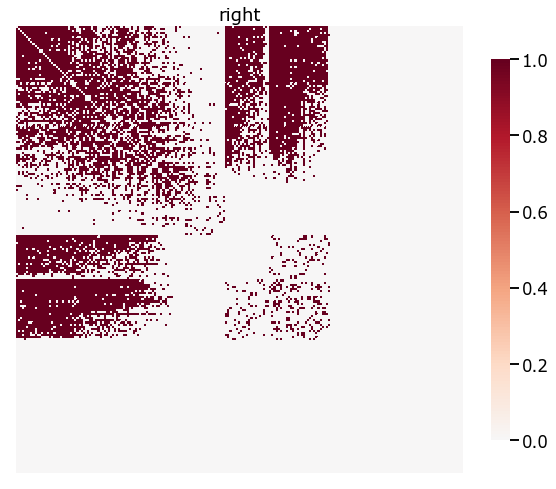

In [14]:
heatmap(right, title='right')

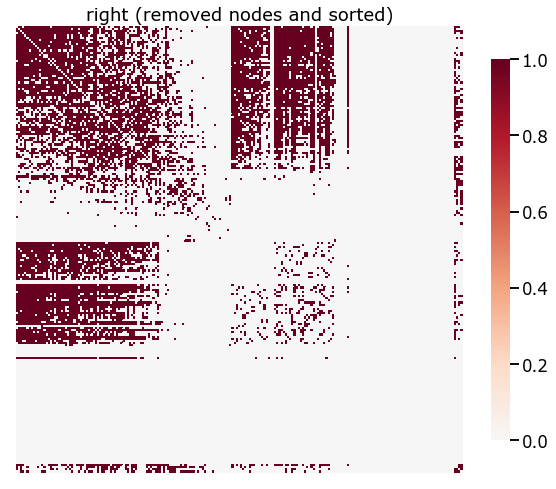

In [15]:
heatmap(right_sorted, title='right (removed nodes and sorted)')

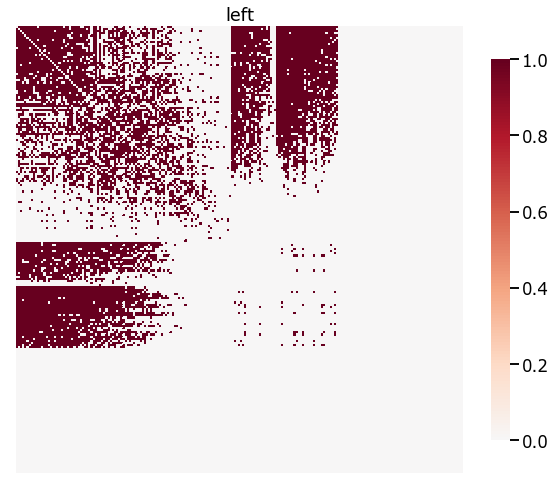

In [16]:
heatmap(left, title='left')

In [17]:
block_assignment = estimate_block_assignment(left, right_sorted, k=10, set_k=False, num_repeats=10)

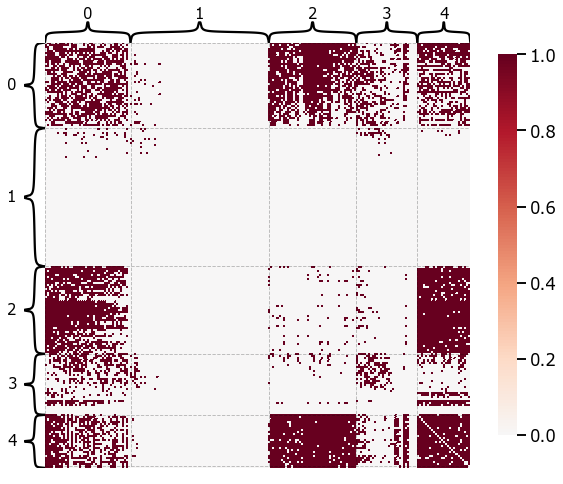

In [18]:
heatmap(left, inner_hier_labels=block_assignment, title='left')

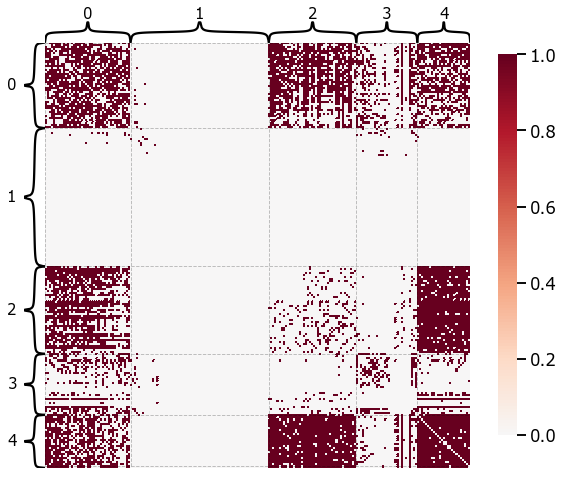

In [19]:
heatmap(right_sorted, inner_hier_labels=block_assignment)

### Fit model

In [9]:
mgc = MGC(compute_distance_matrix=identity)

In [56]:
pval = pvalue(A=left, B=right_sorted, indept_test=mgc, transform_func=to_distance_mtx, block_est_repeats=100,
             k=10, set_k=False)

In [57]:
pval

0.0

In [20]:
mgc.test_statistic(to_distance_mtx(left), to_distance_mtx(right_sorted))

(0.5970284348018199,
 {'local_correlation_matrix': array([[0.59702843, 0.55303397],
         [0.55709532, 0.44819867]]), 'optimal_scale': [1, 1]})

In [22]:
mgc.test_statistic(to_distance_mtx(left), to_distance_mtx(right[:left.shape[0], :left.shape[0]]))

(0.5619846337845182,
 {'local_correlation_matrix': array([[0.56198463, 0.50398256],
         [0.50448054, 0.37542811]]), 'optimal_scale': [1, 1]})

In [73]:
import warnings
warnings.filterwarnings('ignore')

In [79]:
k_arr = np.logspace(start=1, stop=7, num=7, base=2, dtype=int)
reps = 100
test_stats_null_arr = np.zeros((k_arr.size, reps))
for i, k in tqdm(enumerate(k_arr)):
    for r in range(reps):
        block_assignment = estimate_block_assignment(left, right_sorted, k=k, set_k=True, num_repeats=50)
        test_stats_null, _ = mgc.test_statistic(to_distance_mtx(block_permute(left, block_assignment)), 
                   to_distance_mtx(sort_graph(right_sorted, block_assignment)))
        test_stats_null_arr[i, r] = test_stats_null

7it [32:21, 402.83s/it]


[]

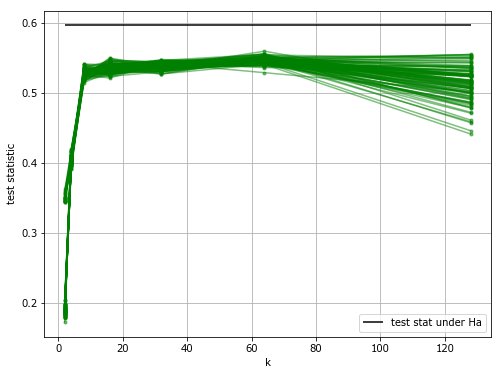

In [80]:
test_stats_alt = mgc.test_statistic(to_distance_mtx(left), to_distance_mtx(right_sorted))[0]
plt.figure(figsize=(8, 6))
for i in range(test_stats_null_arr.shape[1]):
    plt.plot(k_arr, test_stats_null_arr[:, i], color='g', marker='.', alpha=0.5)
plt.hlines(y=test_stats_alt, xmin=min(k_arr), xmax=max(k_arr), label='test stat under Ha')
plt.xlabel('k')
plt.ylabel('test statistic')
plt.legend(loc=4)
plt.grid()
plt.plot()

### Weighted

In [23]:
left = np.loadtxt('../data/drosophila/left_adjacency.csv', dtype=int)
right = np.loadtxt('../data/drosophila/right_adjacency.csv', dtype=int)

# left and right, symmetrized
left = symmetrize(left)
right = symmetrize(right)

right_nx = nx.from_numpy_matrix(right)
right_nx.remove_nodes_from(np.where(graph_match==1)[1][left.shape[0]:])
# right (removed nodes, not sorted)
right_rm = nx.to_numpy_array(right_nx)

# right (removed nodes and sorted)
right_sorted = sort_graph(right_rm, np.where(graph_match==1)[1][:left.shape[0]])

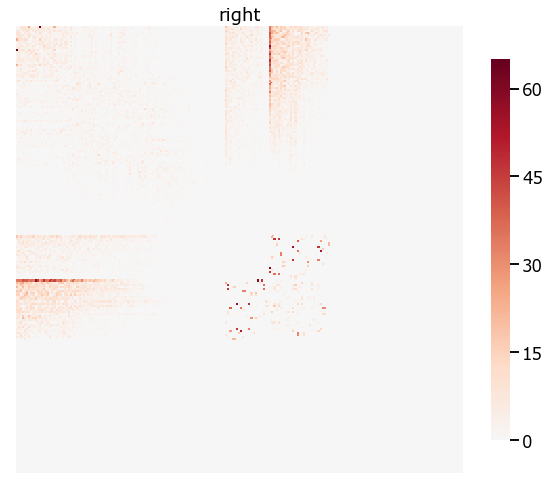

In [24]:
heatmap(right, title='right')

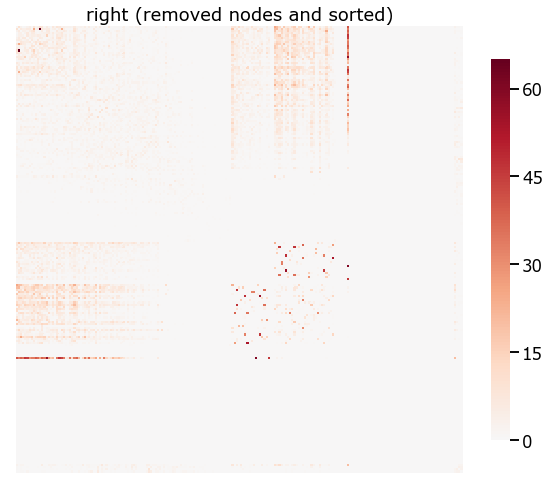

In [25]:
heatmap(right_sorted, title='right (removed nodes and sorted)')

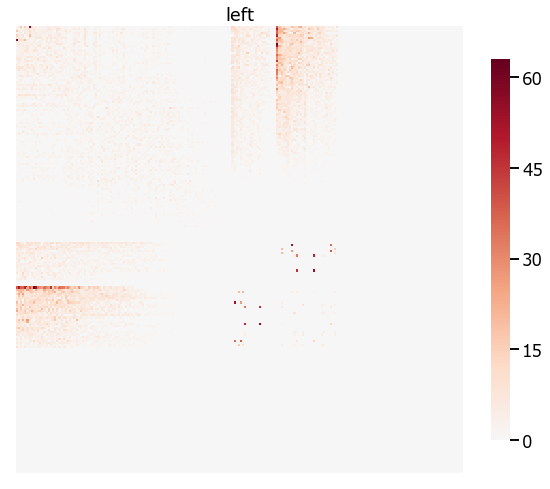

In [26]:
heatmap(left, title='left')

In [27]:
block_assignment = estimate_block_assignment(left, right_sorted, k=10, set_k=False, num_repeats=10)

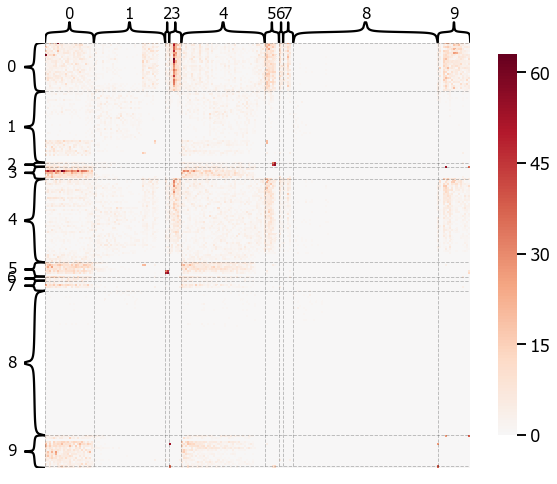

In [28]:
heatmap(left, inner_hier_labels=block_assignment, title='left')

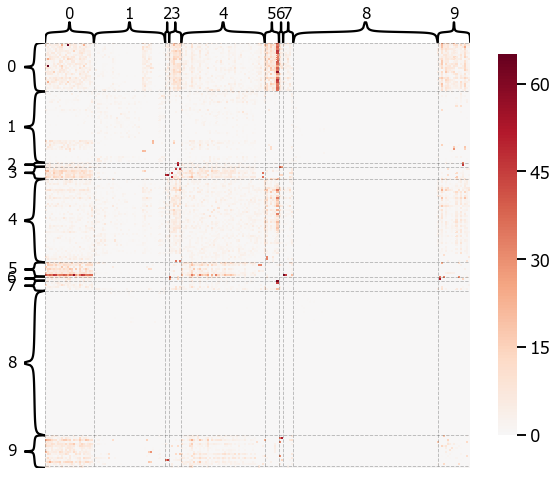

In [29]:
heatmap(right_sorted, inner_hier_labels=block_assignment)

### Fit model

In [9]:
mgc = MGC(compute_distance_matrix=identity)

In [56]:
pval = pvalue(A=left, B=right_sorted, indept_test=mgc, transform_func=to_distance_mtx, block_est_repeats=100,
             k=10, set_k=False)

In [57]:
pval

0.0

In [ ]:
mgc.test_statistic(to_distance_mtx(left), to_distance_mtx(right_sorted))

In [22]:
mgc.test_statistic(to_distance_mtx(left), to_distance_mtx(right[:left.shape[0], :left.shape[0]]))

(0.5619846337845182,
 {'local_correlation_matrix': array([[0.56198463, 0.50398256],
         [0.50448054, 0.37542811]]), 'optimal_scale': [1, 1]})

In [73]:
import warnings
warnings.filterwarnings('ignore')

In [79]:
k_arr = np.logspace(start=1, stop=7, num=7, base=2, dtype=int)
reps = 100
test_stats_null_arr = np.zeros((k_arr.size, reps))
for i, k in tqdm(enumerate(k_arr)):
    for r in range(reps):
        block_assignment = estimate_block_assignment(left, right_sorted, k=k, set_k=True, num_repeats=50)
        test_stats_null, _ = mgc.test_statistic(to_distance_mtx(block_permute(left, block_assignment)), 
                   to_distance_mtx(sort_graph(right_sorted, block_assignment)))
        test_stats_null_arr[i, r] = test_stats_null

7it [32:21, 402.83s/it]


[]

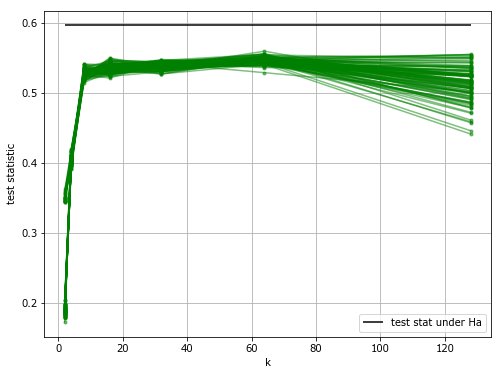

In [80]:
test_stats_alt = mgc.test_statistic(to_distance_mtx(left), to_distance_mtx(right_sorted))[0]
plt.figure(figsize=(8, 6))
for i in range(test_stats_null_arr.shape[1]):
    plt.plot(k_arr, test_stats_null_arr[:, i], color='g', marker='.', alpha=0.5)
plt.hlines(y=test_stats_alt, xmin=min(k_arr), xmax=max(k_arr), label='test stat under Ha')
plt.xlabel('k')
plt.ylabel('test statistic')
plt.legend(loc=4)
plt.grid()
plt.plot()